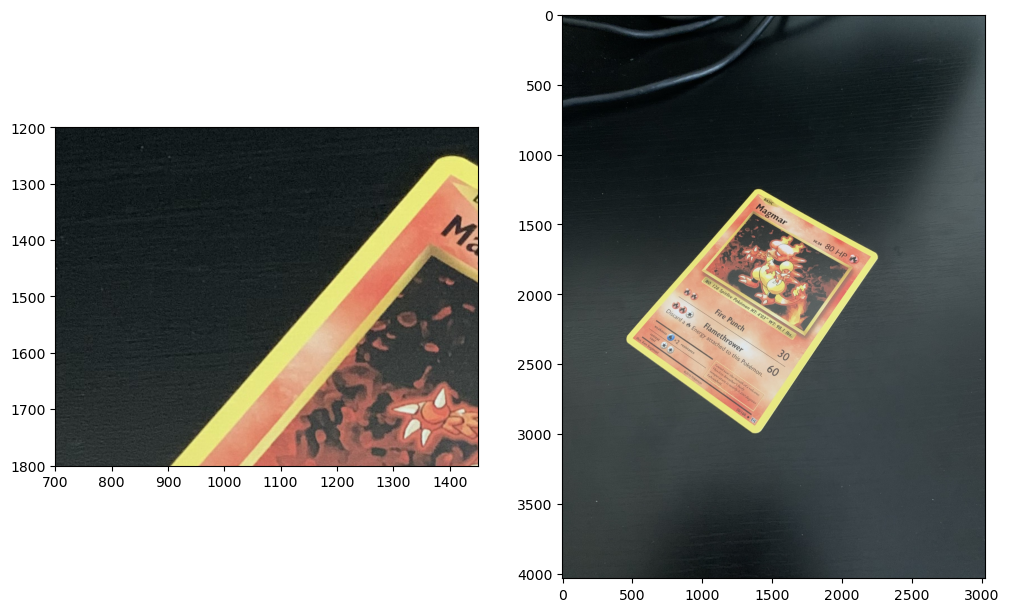

In [768]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image = cv2.imread('test_images/tiltright.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.xlim(700, 1450)
plt.ylim(1800, 1200)
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)

(1800.0, 1200.0)

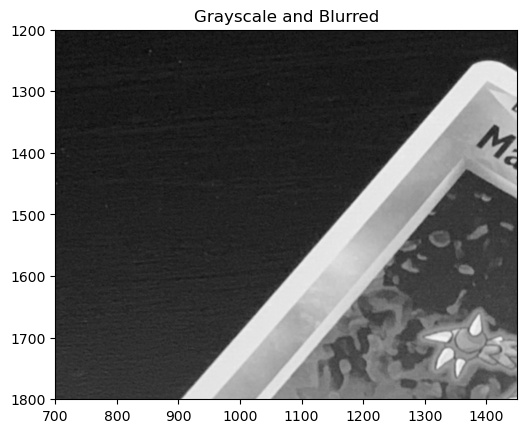

In [769]:
# Step 2: Convert to grayscale and blur
gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(src=gray, ksize=(3, 3), sigmaX=0)
plt.title("Grayscale and Blurred")
plt.imshow(blurred, cmap="gray")
plt.xlim(700, 1450)
plt.ylim(1800, 1200)

(1800.0, 1200.0)

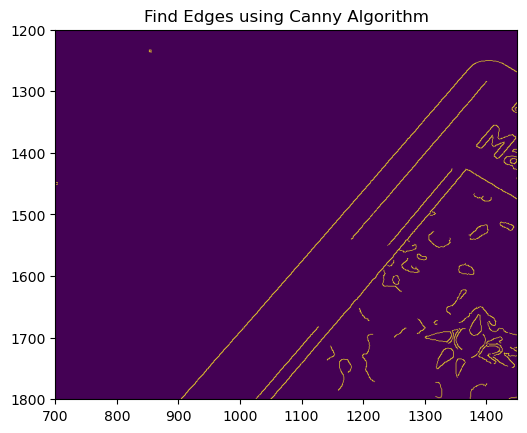

In [770]:
# Step 3a: Edge detection - Canny Algorithm
edges = cv2.Canny(image=blurred, threshold1=100, threshold2=200)
plt.title("Find Edges using Canny Algorithm")
plt.imshow(edges)
plt.xlim(700, 1450)
plt.ylim(1800, 1200)

(1800.0, 1200.0)

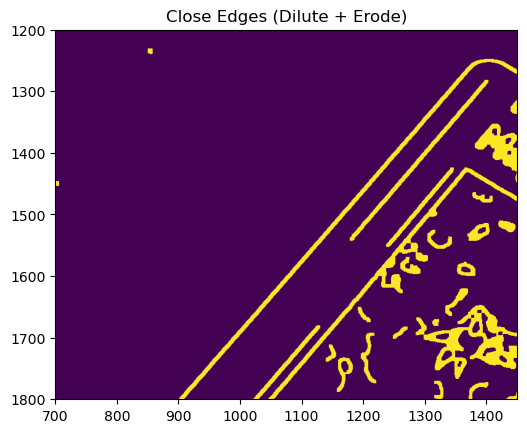

In [771]:
# Step 3b: Edge detection - Dilate and Erode
kernel = np.ones(shape=(5, 5))
dilated = cv2.dilate(src=edges, kernel=kernel, iterations=2)
closed_edges = cv2.erode(src=dilated, kernel=kernel, iterations=1)
plt.title("Close Edges (Dilute + Erode)")
plt.imshow(closed_edges)
plt.xlim(700, 1450)
plt.ylim(1800, 1200)

(3000.0, 1200.0)

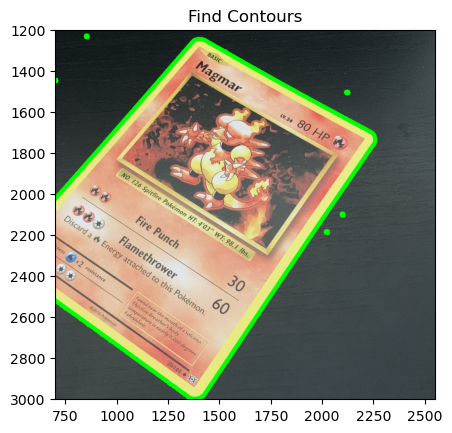

In [772]:
# Step 4a: Contour Processing - Find Contours
contours, _ = cv2.findContours(
    image=closed_edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE
)
contour_image = image.copy()
cv2.drawContours(
    image=contour_image, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=20
)
contour_image_rgb = cv2.cvtColor(src=contour_image, code=cv2.COLOR_BGR2RGB)
plt.title("Find Contours")
plt.imshow(contour_image_rgb)
plt.xlim(700, 2550)
plt.ylim(3000, 1200)

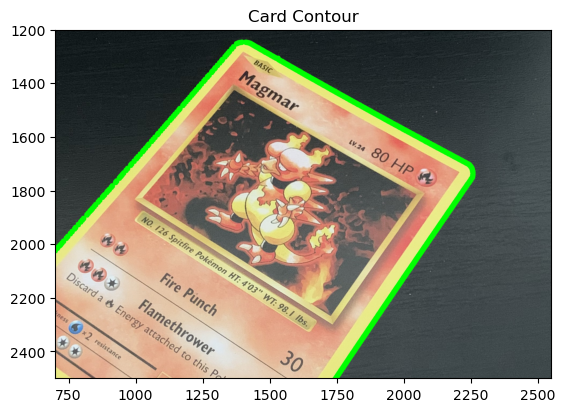

In [773]:
# Step 4b: Contour Processing - Filter Card Contour

EXPECTED_ASPECT_RATIO = 2.5 / 3.5
ASPECT_RATIO_TOLERANCE = 0.2  # Allow 20% deviation from perfect ratio

# Card should typically occupy between 10-50% of the image
MIN_CARD_AREA_PERCENT = 0.10
MAX_CARD_AREA_PERCENT = 0.50 

image_area = closed_edges.shape[0] * closed_edges.shape[1]
min_card_area = image_area * MIN_CARD_AREA_PERCENT
max_card_area = image_area * MAX_CARD_AREA_PERCENT

best_contour = None
best_approx = None

for contour in contours:
    perimeter = cv2.arcLength(curve=contour, closed=True)
    approx = cv2.approxPolyDP(curve=contour, epsilon=0.05 * perimeter, closed=True)
    if len(approx) != 4:
        continue
    area = cv2.contourArea(contour)
    if area < min_card_area or area > max_card_area:
        continue
    rect = cv2.minAreaRect(contour)
    width, height = rect[1]
    if width == 0 or height == 0:
        continue
    aspect_ratio = min(width, height) / max(width, height)
    expected_ratio = min(EXPECTED_ASPECT_RATIO, 1 / EXPECTED_ASPECT_RATIO)
    if abs(aspect_ratio - expected_ratio) > ASPECT_RATIO_TOLERANCE:
        continue
    if best_contour is None or area > cv2.contourArea(best_contour):
        best_contour = contour
        best_approx = approx

if best_contour is not None:
    contour_image = image.copy()
    cv2.drawContours(
        image=contour_image, contours=best_contour, contourIdx=-1, color=(0, 255, 0), thickness=20
    )
    contour_image_rgb = cv2.cvtColor(src=contour_image, code=cv2.COLOR_BGR2RGB)
    plt.title("Card Contour")
    plt.imshow(contour_image_rgb)
    plt.xlim(700, 2550)
    plt.ylim(2500, 1200)
else:
    print("No 4 Sided Contour Found")

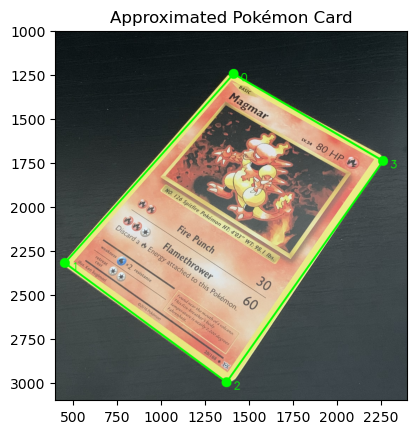

In [774]:
# Step 5: Draw the 4 Sided Card Approximation
if best_contour is not None:
    approx_image = image.copy()
    
    for idx, point in enumerate(best_approx):
        x, y = point[0]
        cv2.circle(
            img=approx_image, center=(x, y), radius=3, color=(0, 255, 0), thickness=50
        )
        text_offset = 40
        cv2.putText(
            img=approx_image,
            text=str(idx),
            org=(x + text_offset, y + text_offset),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=2, color=(0, 255, 0),
            thickness=3
        )
    cv2.drawContours(
        image=approx_image, contours=[best_approx], contourIdx=-1,
        color=(0, 255, 0), thickness=10
    )
    
    approx_image_rgb = cv2.cvtColor(src=approx_image, code=cv2.COLOR_BGR2RGB)
    plt.imshow(approx_image_rgb)
    plt.title('Approximated Pokémon Card')
    plt.xlim(400, 2400)
    plt.ylim(3100, 1000)

In [775]:
# Step 5: Reorder the corners

# Order needs to be top-left, top-right, bottom-right, bottom-left

corners = np.array(best_approx).reshape(4, 2)

coord_sums = corners.sum(axis=1)

sorted_indices = np.argsort(coord_sums)

top_left = corners[sorted_indices[0]]
bottom_right = corners[sorted_indices[3]]

is_titled_right = corners[sorted_indices[1]][1] > corners[sorted_indices[2]][1]
if is_titled_right:
    top_right = corners[sorted_indices[2]]
    bottom_left = corners[sorted_indices[1]]
else:
    top_right = corners[sorted_indices[1]]
    bottom_left = corners[sorted_indices[2]]

ordered_corners = np.array([
    top_left,
    top_right,
    bottom_right,
    bottom_left,
], dtype="float32")

(3100.0, 1000.0)

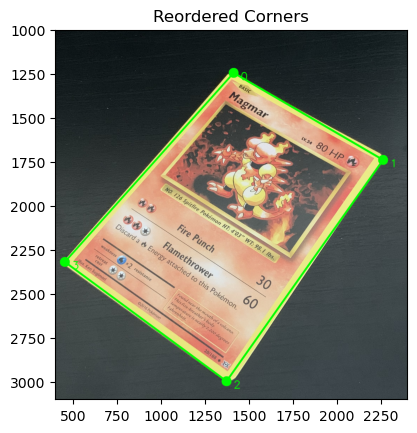

In [776]:
approx_image = image.copy()
for idx, point in enumerate(ordered_corners):
    x, y = point.astype(int)  # Convert to integer coordinates
    cv2.circle(img=approx_image, center=(x, y), radius=3, color=(0, 255, 0), thickness=50)
    text_offset = 40
    cv2.putText(
        img=approx_image,
        text=str(idx),
        org=(x + text_offset, y + text_offset),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2,
        color=(0, 255, 0),
        thickness=3
    )
cv2.drawContours(
    image=approx_image,
    contours=[ordered_corners.astype(int).reshape(-1, 1, 2)],  # Reshape for drawContours
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=10
)
approx_image_rgb = cv2.cvtColor(src=approx_image, code=cv2.COLOR_BGR2RGB)
plt.imshow(approx_image_rgb)
plt.title('Reordered Corners')
plt.xlim(400, 2400)
plt.ylim(3100, 1000)

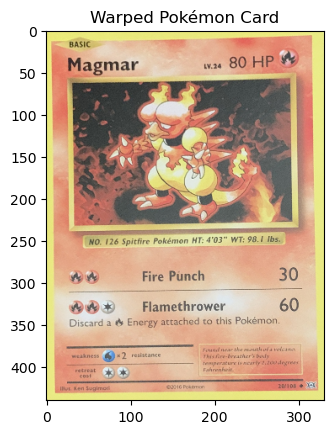

In [777]:
# Step 6: Warp the image to a Rectangle
    
width, height = 330, 440
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')

# Get the perspective transform matrix
matrix = cv2.getPerspectiveTransform(src=ordered_corners, dst=dst)
warped = cv2.warpPerspective(src=image, M=matrix, dsize=(width, height))

warped_rgb = cv2.cvtColor(src=warped, code=cv2.COLOR_BGR2RGB)
plt.imshow(warped_rgb)
plt.title('Warped Pokémon Card')
plt.show()

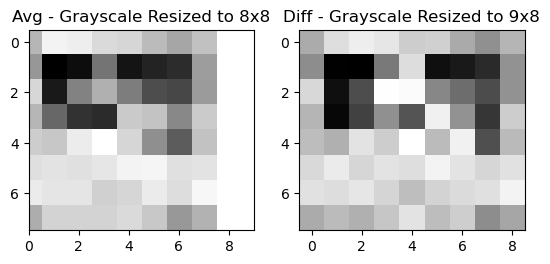

In [778]:
# Step 7 Image Hashing - Convert to Grayscale

gray = cv2.cvtColor(src=warped, code=cv2.COLOR_BGR2GRAY)
HASH_SIZE = 8
gray_resized_avg = cv2.resize(gray, (HASH_SIZE, HASH_SIZE))
gray_resized_diff = cv2.resize(gray, (HASH_SIZE + 1, HASH_SIZE))


plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(gray_resized_avg, cmap="gray")
ax = plt.gca()
ax.set_xlim([0, 9])
plt.title('Avg - Grayscale Resized to 8x8')
plt.subplot(1, 2, 2)
plt.imshow(gray_resized_diff, cmap="gray")
plt.title('Diff - Grayscale Resized to 9x8')
plt.show()

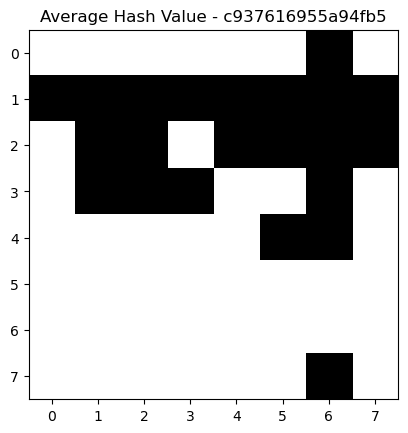

In [779]:
avg_pixel = np.mean(gray_resized)
diff = gray_resized > avg_pixel
hash_str = "".join(["1" if b else "0" for b in diff.flatten()])
avg_hash = hex(int(hash_str, 2))[2:].zfill(16)
plt.imshow(diff, cmap="gray")
plt.title(f'Average Hash Value - {hash_hex}')
plt.show()

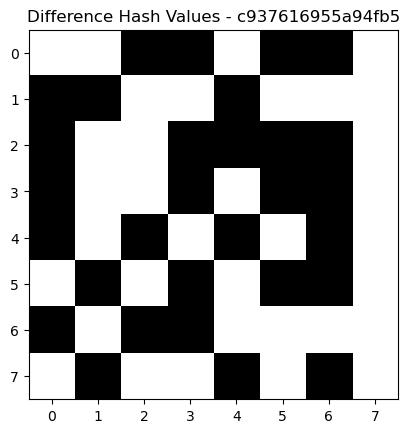

In [780]:
diff = gray_resized_diff[:, 1:] > gray_resized_diff[:, :-1]
hash_str = "".join(["1" if b else "0" for b in diff.flatten()])
diff_hash = hex(int(hash_str, 2))[2:].zfill(16)
plt.imshow(diff, cmap="gray")
plt.title(f'Difference Hash Values - {hash_hex}')
plt.show()

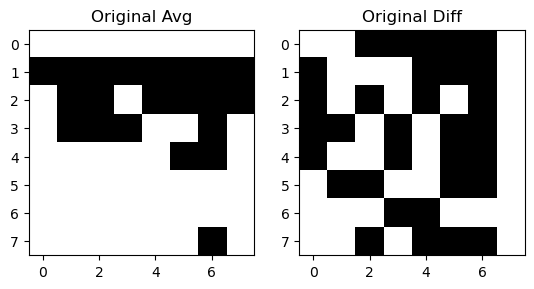

In [781]:
# Computer hash of original
img = cv2.imread("test_images/magmar_original.jpg")
gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
HASH_SIZE = 8
gray_resized_avg = cv2.resize(gray, (HASH_SIZE, HASH_SIZE))
gray_resized_diff = cv2.resize(gray, (HASH_SIZE + 1, HASH_SIZE))
avg_pixel = np.mean(gray_resized_avg)
original_diff_avg = gray_resized > avg_pixel
hash_str = "".join(["1" if b else "0" for b in original_diff_avg.flatten()])
original_avg_hash = hex(int(hash_str, 2))[2:].zfill(16)

original_diff = gray_resized_diff[:, 1:] > gray_resized_diff[:, :-1]
hash_str = "".join(["1" if b else "0" for b in original_diff.flatten()])
original_diff_hash = hex(int(hash_str, 2))[2:].zfill(16)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(original_diff_avg, cmap="gray")
plt.title('Original Avg')
plt.subplot(1, 2, 2)
plt.imshow(original_diff, cmap="gray")
plt.title('Original Diff')
plt.show()

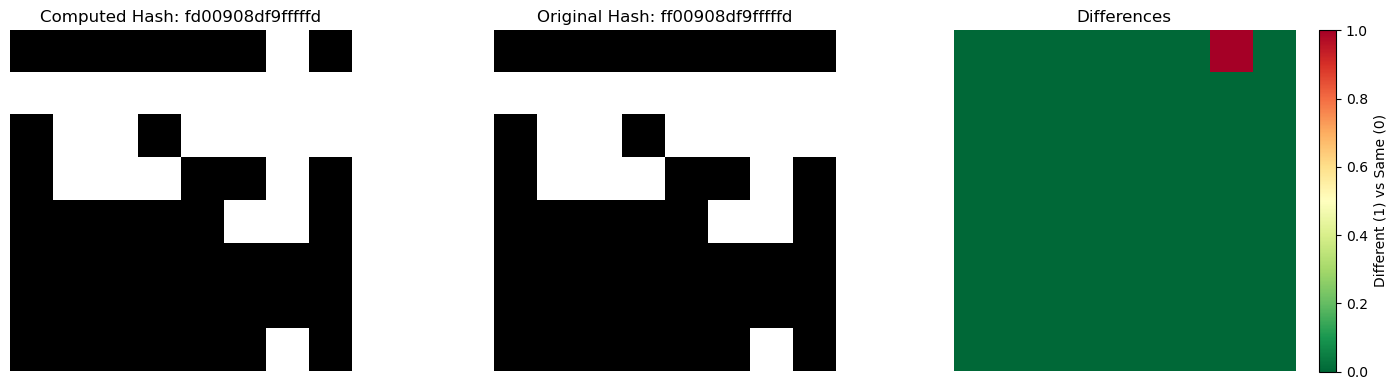

In [793]:
# Avg Hash Comparison

# Convert hex strings to binary matrices
hash1 = avg_hash
hash2 = original_avg_hash

# Convert hex to binary string, pad to 64 bits
binary1 = bin(int(hash1, 16))[2:].zfill(64)
binary2 = bin(int(hash2, 16))[2:].zfill(64)

# Reshape into 8x8 matrices
matrix1 = np.array([int(b) for b in binary1]).reshape(8, 8)
matrix2 = np.array([int(b) for b in binary2]).reshape(8, 8)

# Calculate differences
diff = matrix1 != matrix2

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.imshow(matrix1, cmap='binary')
ax1.set_title(f'Computed Hash: {hash1}')
ax1.axis('off')
ax2.imshow(matrix2, cmap='binary')
ax2.set_title(f'Original Hash: {hash2}')
ax2.axis('off')
diff_plot = ax3.imshow(diff, cmap='RdYlGn_r')  # Red for differences, green for matches
ax3.set_title('Differences')
ax3.axis('off')

plt.colorbar(diff_plot, ax=ax3, label='Different (1) vs Same (0)')

plt.tight_layout()
plt.show()
avg_hamming_distance = np.sum(diff)

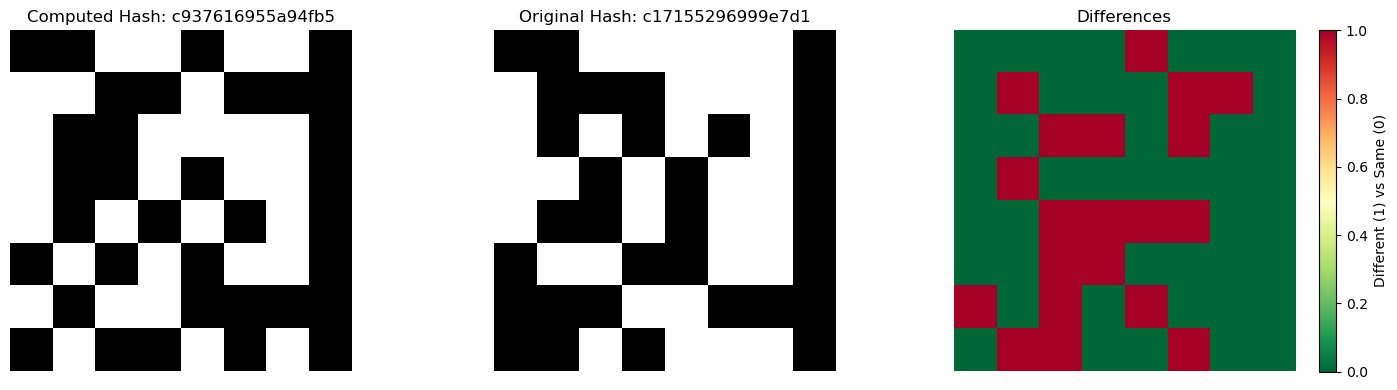

In [794]:
# Diff Hash Comparison

# Convert hex strings to binary matrices
hash1 = diff_hash
hash2 = original_diff_hash

# Convert hex to binary string, pad to 64 bits
binary1 = bin(int(hash1, 16))[2:].zfill(64)
binary2 = bin(int(hash2, 16))[2:].zfill(64)

# Reshape into 8x8 matrices
matrix1 = np.array([int(b) for b in binary1]).reshape(8, 8)
matrix2 = np.array([int(b) for b in binary2]).reshape(8, 8)

# Calculate differences
diff = matrix1 != matrix2

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.imshow(matrix1, cmap='binary')
ax1.set_title(f'Computed Hash: {hash1}')
ax1.axis('off')
ax2.imshow(matrix2, cmap='binary')
ax2.set_title(f'Original Hash: {hash2}')
ax2.axis('off')
diff_plot = ax3.imshow(diff, cmap='RdYlGn_r')  # Red for differences, green for matches
ax3.set_title('Differences')
ax3.axis('off')

plt.colorbar(diff_plot, ax=ax3, label='Different (1) vs Same (0)')

plt.tight_layout()
plt.show()

diff_hamming_distance = np.sum(diff)

In [795]:
hamming_distance = 0.8 * avg_hamming_distance + 0.2 * diff_hamming_distance

threshold = 24.0
min_diff = hamming_distance 

confidence = max(0.0, min(1.0, 1.0 - (min_diff / threshold)))
match_quality = "High" if confidence > 0.5 else "Low"
print(f"Confidence: {confidence:.2f}, Match Quality: {match_quality}")

Confidence: 0.80, Match Quality: High
